In [1]:
import pandas as pd
import category_encoders as ce

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from itables import show
from ridgeReg import RidgeReg

In [2]:
df = pd.read_csv("dataset.csv", index_col=0)

df["explicit"] = df["explicit"].astype(int)

# fix duplicates track_ids
grouped = df.groupby(by='track_id')
fixed = grouped.agg({"popularity":"mean","track_genre":lambda x: ';'.join(x)})
fixed[fixed['track_genre'].str.contains(';')]
df_dropped = df.drop_duplicates(subset=['track_id'])
df_new = df_dropped.set_index('track_id')
df_new['track_genre'] = fixed['track_genre']
df_new['popularity'] = fixed['popularity']

#df = df.drop('track_id',axis=1)
df_new = df_new.reset_index(drop=True)
show(df_new)
df=df_new

In [3]:
def test_train_split(df,random_state=1):
  df_train = df.sample(frac=0.8,random_state=random_state)
  df_train_x = df_train.drop('popularity',axis=1)
  df_train_y = df_train['popularity']

  df_test = df.drop(df_train.index)
  df_test_x = df_test.drop('popularity',axis=1)
  df_test_y = df_test['popularity']
  return (df_train_x,df_train_y,df_test_x,df_test_y)

In [4]:
def test_my_ridge(train_x,train_y,test_x,test_y,alpha=0,print_pred=False):
  ridge = RidgeReg(alpha)
  print('Training ridge regression...')
  ridge.fit(train_x,train_y)

  print('Predicting values...')
  pred = ridge.predict(test_x)
  if(print_pred):
    print('Predictions: ')
    print([(x,y) for (x,y) in zip(test_y,pred)])
  pred_train = ridge.predict(train_x)

  score_test = ridge.r2_score(test_y,pred)
  mse_test = ridge.mse(test_y,pred)
  score_train = ridge.r2_score(train_y,pred_train)
  mse_train = ridge.mse(train_y,pred_train)
  print(f'R2 score: {score_train, score_test}')
  print(f'MSE: {mse_train, mse_test}')
  return score_train,score_test,mse_train,mse_test

In [5]:
def k_fold_testing(df,encoder,alpha=0,random_state=1):
  X = df.drop('popularity',axis=1)
  y = df['popularity']
  kf = KFold(n_splits=5,shuffle=True,random_state=random_state)
  train_scores = []
  test_scores = []
  train_mse = []
  test_mse = []
  for (train_index,test_index) in kf.split(df):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]

    if(encoder.needs_y):
      enc = encoder.fit(X_train,y_train)
    else:
      enc = encoder.fit(X_train)
    
    df_train_x = enc.transform(X_train)
    df_test_x = enc.transform(X_test)

    scaler = StandardScaler()
    scaler.fit(df_train_x)
    df_train_x = pd.DataFrame(scaler.transform(df_train_x),columns=df_train_x.columns)
    df_test_x = pd.DataFrame(scaler.transform(df_test_x),columns=df_test_x.columns)

    #enc2 = ce.OneHotEncoder(cols=['track_genre']).fit(bin_df_train_x)
    #bin_df_train_x = enc2.transform(bin_df_train_x)
    #bin_df_test_x = enc2.transform(bin_df_test_x)
    score = test_my_ridge(df_train_x,y_train,df_test_x,y_test,alpha)
    train_scores.append(score[0])
    test_scores.append(score[1])
    train_mse.append(score[2])
    test_mse.append(score[3])
  print(train_scores)
  print(sum(train_scores)/len(train_scores)) # 0.014007646151338538
  print(test_scores)
  print(sum(test_scores)/len(test_scores)) # -0.0378098150148428
  print(train_mse)
  print(sum(train_mse)/len(train_mse))
  print(test_mse)
  print(sum(test_mse)/len(test_mse))
  return (train_scores,test_scores,train_mse,test_mse)


# One Hot Encoder

In [6]:
#enc = ce.OneHotEncoder(cols=['artists']).fit(df)
#genre = enc.transform(df)
#genre

# Binary encoder

In [7]:
encoder = ce.BinaryEncoder(cols=['artists','track_name','album_name','track_genre'])
encoder.needs_y = False
bin_train_r2,bin_test_r2,bin_train_mse,bin_test_mse = k_fold_testing(df,encoder,0,1)

Training ridge regression...
Predicting values...
R2 score: (0.1970195162742806, -0.2718949500248655)
MSE: (340.97027939504994, 531.8178053519525)
Training ridge regression...
Predicting values...
R2 score: (0.20033777945774645, -0.25894307016407603)
MSE: (338.0709966147409, 535.8608024249868)
Training ridge regression...
Predicting values...
R2 score: (0.19927062585158606, -0.27648278893471656)
MSE: (339.74534584921923, 535.4732134727956)
Training ridge regression...
Predicting values...
R2 score: (0.2131061155187981, -0.19266592850549102)
MSE: (332.19614668902466, 510.54842749353116)
Training ridge regression...
Predicting values...
R2 score: (0.21189567975789636, -0.3034838936212376)
MSE: (333.2577318273703, 554.3311899427099)
[0.1970195162742806, 0.20033777945774645, 0.19927062585158606, 0.2131061155187981, 0.21189567975789636]
0.2043259433720615
[-0.2718949500248655, -0.25894307016407603, -0.27648278893471656, -0.19266592850549102, -0.3034838936212376]
-0.2606941262500774
[340.970

# Ordinal encoder

In [8]:
encoder = ce.OrdinalEncoder(cols=['artists','track_name','album_name','track_genre'])
encoder.needs_y = False
ord_train_r2,ord_test_r2,ord_train_mse,ord_test_mse = k_fold_testing(df,encoder,0,1)

Training ridge regression...
Predicting values...
R2 score: (0.1285894652853593, -0.21953351334118953)
MSE: (370.02778960557197, 509.9239026034249)
Training ridge regression...
Predicting values...
R2 score: (0.13011546082482484, -0.2251768000824388)
MSE: (367.7586930382776, 521.4884125928661)
Training ridge regression...
Predicting values...
R2 score: (0.12796511267083022, -0.2365892612060012)
MSE: (369.99990752596096, 518.7382322612676)
Training ridge regression...
Predicting values...
R2 score: (0.12850625267427684, -0.2265701694854756)
MSE: (367.91093492365263, 525.061927463622)
Training ridge regression...
Predicting values...
R2 score: (0.12507719495738778, -0.2141428996489707)
MSE: (369.96978958695524, 516.3372417691531)
[0.1285894652853593, 0.13011546082482484, 0.12796511267083022, 0.12850625267427684, 0.12507719495738778]
0.1280506972825358
[-0.21953351334118953, -0.2251768000824388, -0.2365892612060012, -0.2265701694854756, -0.2141428996489707]
-0.22440252875281516
[370.02778

# Target Encoder

In [9]:
encoder = ce.TargetEncoder(cols=['artists','track_name','album_name','track_genre'])
encoder.needs_y = True
tgt_train_r2,tgt_test_r2,tgt_train_mse,tgt_test_mse = k_fold_testing(df,encoder,0,1)

Training ridge regression...
Predicting values...
R2 score: (0.7802980559410775, 0.5071456950150116)
MSE: (93.29222162639098, 206.07731387741904)
Training ridge regression...
Predicting values...
R2 score: (0.7873887698606568, 0.49633955717318323)
MSE: (89.88506474140206, 214.37974078345545)
Training ridge regression...
Predicting values...
R2 score: (0.7746547074553003, 0.5207124587391865)
MSE: (95.61284601618999, 201.0568745001141)
Training ridge regression...
Predicting values...
R2 score: (0.7797983858692321, 0.49508041642313516)
MSE: (92.96060009053488, 216.14258716091936)
Training ridge regression...
Predicting values...
R2 score: (0.7824289190912368, 0.5002492680788098)
MSE: (92.00209042453882, 212.52845490173078)
[0.7802980559410775, 0.7873887698606568, 0.7746547074553003, 0.7797983858692321, 0.7824289190912368]
0.7809137676435006
[0.5071456950150116, 0.49633955717318323, 0.5207124587391865, 0.49508041642313516, 0.5002492680788098]
0.5039054790858651
[93.29222162639098, 89.8850

# Cat Boost Encoder

In [10]:
encoder = ce.CatBoostEncoder(cols=['artists','track_name','album_name','track_genre'])
encoder.needs_y = True
cat_train_r2,cat_test_r2,cat_train_mse,cat_test_mse = k_fold_testing(df,encoder,0,1) 

Training ridge regression...
Predicting values...
R2 score: (0.7357367928681191, 0.6436805724233241)
MSE: (112.21430831233947, 148.9879458790108)
Training ridge regression...
Predicting values...
R2 score: (0.7360443811577968, 0.646011507399508)
MSE: (111.59179067323359, 150.672863761337)
Training ridge regression...
Predicting values...
R2 score: (0.7353804646925515, 0.6470465599732995)
MSE: (112.27670476945107, 148.06083903027135)
Training ridge regression...
Predicting values...
R2 score: (0.7352041508405082, 0.6376065105982289)
MSE: (111.78656040518862, 155.13097316346796)
Training ridge regression...
Predicting values...
R2 score: (0.7351936201879439, 0.6424443994443765)
MSE: (111.97600526091922, 152.05728470955134)
[0.7357367928681191, 0.7360443811577968, 0.7353804646925515, 0.7352041508405082, 0.7351936201879439]
0.7355118819493839
[0.6436805724233241, 0.646011507399508, 0.6470465599732995, 0.6376065105982289, 0.6424443994443765]
0.6433579099677473
[112.21430831233947, 111.59179

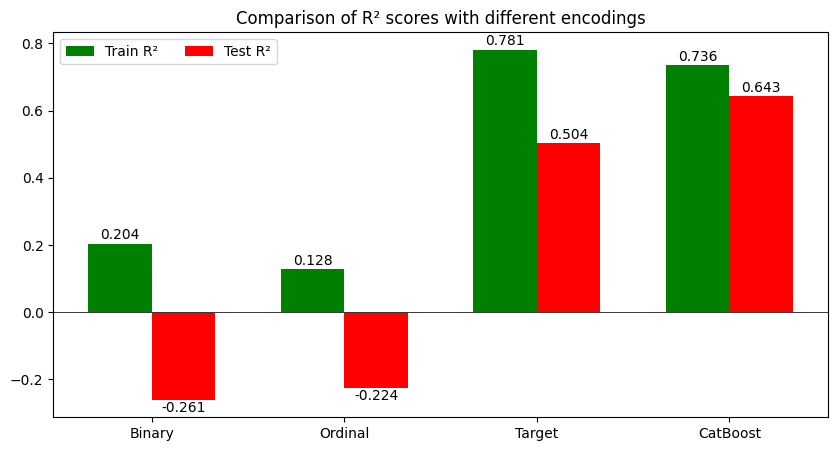

In [11]:
import matplotlib.pyplot as plt
import numpy as np

train_r2 = [bin_train_r2,ord_train_r2,tgt_train_r2,cat_train_r2]
test_r2 = [bin_test_r2]
train_mse = [bin_train_mse]
test_mse = [bin_test_mse]
data = {
  'Train R²': (list(map(np.mean,[bin_train_r2,ord_train_r2,tgt_train_r2,cat_train_r2])),'green'),
  'Test R²': (list(map(np.mean,[bin_test_r2,ord_test_r2,tgt_test_r2,cat_test_r2])),'red'),
}
x = np.arange(4)
width = 0.33
multiplier = 0
plt.rcParams["figure.figsize"] = (10,5)
fig,ax = plt.subplots()
for attribute,(measurements,color) in data.items():
  offset = width*multiplier
  rects = ax.bar(x+offset,measurements,width,label=attribute,color=color)
  ax.bar_label(rects, padding=1,fmt='%.3f')
  multiplier+=1
ax.axhline(0,color='#373737',linewidth=0.7) # x = 0
ax.set_xticks(x+width/2, ['Binary','Ordinal','Target','CatBoost'])
ax.legend(loc='upper left', ncols=3)
ax.set_title('Comparison of R² scores with different encodings')
plt.show()


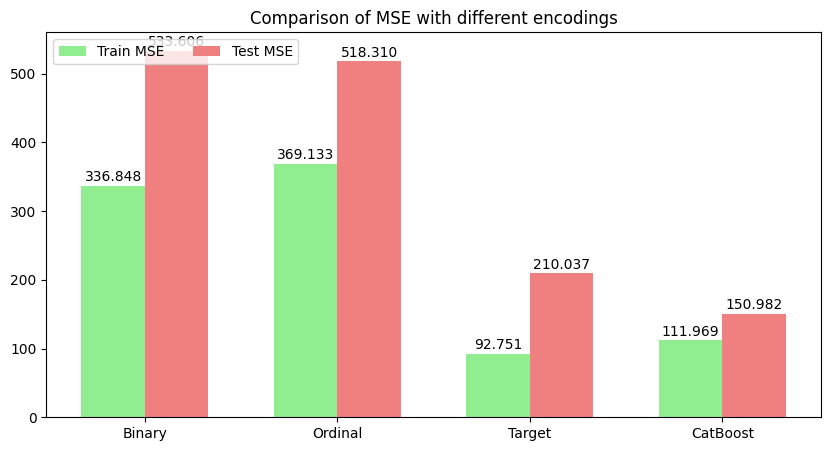

In [15]:
import matplotlib.pyplot as plt
import numpy as np

train_r2 = [bin_train_r2,ord_train_r2,tgt_train_r2,cat_train_r2]
test_r2 = [bin_test_r2]
train_mse = [bin_train_mse]
test_mse = [bin_test_mse]
data = {
  'Train MSE': (list(map(np.mean,[bin_train_mse,ord_train_mse,tgt_train_mse,cat_train_mse])),'lightgreen'),
  'Test MSE': (list(map(np.mean,[bin_test_mse,ord_test_mse,tgt_test_mse,cat_test_mse])),'lightcoral'),
}
x = np.arange(4)
width = 0.33
multiplier = 0
plt.rcParams["figure.figsize"] = (10,5)
fig,ax = plt.subplots()
for attribute,(measurements,color) in data.items():
  offset = width*multiplier
  rects = ax.bar(x+offset,measurements,width,label=attribute,color=color)
  ax.bar_label(rects, padding=1,fmt='%.3f')
  multiplier+=1
ax.axhline(0,color='#373737',linewidth=0.7) # x = 0
ax.set_xticks(x+width/2, ['Binary','Ordinal','Target','CatBoost'])
ax.legend(loc='upper left', ncols=3)
ax.set_title('Comparison of MSE with different encodings')
plt.show()


In [13]:
#encoder = ce.BaseNEncoder(cols=['artists','track_name','album_name','track_genre'],base=2)
#encoder.needs_y = False
#tgt_train_r2,tgt_test_r2,tgt_train_mse,tgt_test_mse = k_fold_testing(df,encoder,0,1)

Failed: Backward Difference, Helmert, Polynomial, Sum